# "DRAW: A Recurrent Neural Network For Image Generation" paper implementation - https://arxiv.org/pdf/1502.04623.pdf

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm

USE_CUDA = torch.cuda.is_available()

In [12]:
class DrawModel(nn.Module):
    def __init__(self,T,A,B,z_size,N,dec_size,enc_size):
        super(DrawModel,self).__init__()
        self.T = T
        self.A = A
        self.B = B
        self.z_size = z_size
        self.N = N
        self.dec_size = dec_size
        self.enc_size = enc_size

        self.cs = [0] * T
        self.logsigmas,self.sigmas,self.mus = [0] * T,[0] * T,[0] * T

        self.encoder = nn.LSTMCell(2 * N * N + dec_size, enc_size)
        self.encoder_gru = nn.GRUCell(2 * N * N + dec_size, enc_size)
        self.mu_linear = nn.Linear(dec_size, z_size)
        self.sigma_linear = nn.Linear(dec_size, z_size)

        self.decoder = nn.LSTMCell(z_size,dec_size)
        self.decoder_gru = nn.GRUCell(z_size,dec_size)
        self.dec_linear = nn.Linear(dec_size,5)
        self.dec_w_linear = nn.Linear(dec_size,N*N)

        self.sigmoid = nn.Sigmoid()
        
    def unit_prefix(x, n=1):
      for i in range(n): x = x.unsqueeze(0)
      return x
  
    def align(self, x, y, start_dim=0):
      xd, yd = x.dim(), y.dim()
      if xd > yd: y = self.unit_prefix(y, xd - yd)
      elif yd > xd: x = self.unit_prefix(x, yd - xd)

      xs, ys = list(x.size()), list(y.size())
      nd = len(ys)
      for i in range(start_dim, nd):
          td = nd-i-1
          if   ys[td]==1: ys[td] = xs[td]
          elif xs[td]==1: xs[td] = ys[td]
      return x.expand(*xs), y.expand(*ys)


    def normalSample(self):
        return torch.randn(self.batch_size,self.z_size)

    def compute_mu(self,g,rng,delta):
        rng_t,delta_t = self.align(rng,delta)
        tmp = (rng_t - self.N / 2 - 0.5) * delta_t
        tmp_t,g_t = self.align(tmp,g)
        mu = tmp_t + g_t
        return mu

    def filterbank(self,gx,gy,sigma2,delta):
        rng = torch.arange(0,self.N).view(1,-1)
        
        if USE_CUDA:
            rng = rng.cuda()
        
        mu_x = self.compute_mu(gx,rng,delta)
        mu_y = self.compute_mu(gy,rng,delta)

        a = torch.arange(0,self.A).view(1,1,-1)
        b = torch.arange(0,self.B).view(1,1,-1)

        mu_x = mu_x.view(-1,self.N,1)
        mu_y = mu_y.view(-1,self.N,1)
        sigma2 = sigma2.view(-1,1,1)
        
        Fx = self.filterbank_matrices(a,mu_x,sigma2)
        Fy = self.filterbank_matrices(b,mu_y,sigma2)

        return Fx,Fy
    
    def filterbank_matrices(self,a,mu_x,sigma2,epsilon=1e-9):
        t_a,t_mu_x = self.align(a,mu_x)
        
        if USE_CUDA:
            t_a = t_a.cuda()
            t_mu_x = t_mu_x.cuda()
        
        temp = t_a - t_mu_x
        temp,t_sigma = self.align(temp,sigma2)
        temp = temp / (t_sigma * 2)
        F = torch.exp(-torch.pow(temp,2))
        F = F / (F.sum(2,True).expand_as(F) + epsilon)
        return F

    def forward(self,x):
        self.batch_size = x.size()[0]
        h_dec_prev = torch.zeros(self.batch_size,self.dec_size)
        h_enc_prev = torch.zeros(self.batch_size, self.enc_size)

        enc_state = torch.zeros(self.batch_size,self.enc_size)
        dec_state = torch.zeros(self.batch_size, self.dec_size)
        
        if USE_CUDA:
            h_dec_prev = h_dec_prev.cuda()
            h_enc_prev = h_enc_prev.cuda()
            enc_state = enc_state.cuda()
            dec_state = dec_state.cuda()
        
        for t in range(self.T):
            c_prev = torch.zeros(self.batch_size,self.A * self.B) if t == 0 else self.cs[t-1]
            
            if USE_CUDA:
                c_prev = c_prev.cuda()
            
            x_hat = x - self.sigmoid(c_prev)
            r_t = self.read(x,x_hat,h_dec_prev)
            h_enc_prev, enc_state = self.encoder(torch.cat((r_t,h_dec_prev),1), (h_enc_prev,enc_state))
            z, self.mus[t], self.logsigmas[t], self.sigmas[t] = self.sampleQ(h_enc_prev)
            h_dec,dec_state = self.decoder(z, (h_dec_prev, dec_state))
            self.cs[t] = c_prev + self.write(h_dec)
            h_dec_prev = h_dec

    def loss(self,x):
        self.forward(x)
        criterion = nn.BCELoss()
        x_recons = self.sigmoid(self.cs[-1])
        Lx = criterion(x_recons,x) * self.A * self.B
        Lz = 0
        kl_terms = [0] * self.T
        for t in range(self.T):
            mu_2 = self.mus[t] * self.mus[t]
            sigma_2 = self.sigmas[t] * self.sigmas[t]
            logsigma = self.logsigmas[t]
            kl_terms[t] = 0.5 * torch.sum(mu_2+sigma_2-2 * logsigma,1) - self.T * 0.5
            Lz += kl_terms[t]
        Lz = torch.mean(Lz)
        loss = Lz + Lx
        return loss

    def attn_window(self,h_dec):
        params = self.dec_linear(h_dec)
        gx_,gy_,log_sigma_2,log_delta,log_gamma = params.split(1,1)

        gx = (self.A + 1) / 2 * (gx_ + 1)
        gy = (self.B + 1) / 2 * (gy_ + 1)
        delta = (max(self.A,self.B) - 1) / (self.N - 1) * torch.exp(log_delta)
        sigma2 = torch.exp(log_sigma_2)
        gamma = torch.exp(log_gamma)
        return self.filterbank(gx,gy,sigma2,delta),gamma

    def read(self,x,x_hat,h_dec_prev):
        (Fx,Fy),gamma = self.attn_window(h_dec_prev)
        
        def filter_img(img,Fx,Fy,gamma,A,B,N):
            Fxt = Fx.transpose(2,1)
            img = img.view(-1,B,A)
            glimpse = Fy.bmm(img.bmm(Fxt))
            glimpse = glimpse.view(-1,N*N)
            return glimpse * gamma.view(-1,1).expand_as(glimpse)
        
        x = filter_img(x,Fx,Fy,gamma,self.A,self.B,self.N)
        x_hat = filter_img(x_hat,Fx,Fy,gamma,self.A,self.B,self.N)
        return torch.cat((x,x_hat),1)

    def write(self,h_dec=0):
        w = self.dec_w_linear(h_dec)
        w = w.view(self.batch_size,self.N,self.N)
        (Fx,Fy),gamma = self.attn_window(h_dec)
        Fyt = Fy.transpose(2,1)
        wr = Fyt.bmm(w.bmm(Fx))
        wr = wr.view(self.batch_size,self.A*self.B)
        return wr / gamma.view(-1,1).expand_as(wr)

    def sampleQ(self,h_enc):
        e = self.normalSample()
        mu = self.mu_linear(h_enc)
        log_sigma = self.sigma_linear(h_enc)
        sigma = torch.exp(log_sigma)
        
        if USE_CUDA:
            e = e.cuda()
            sigma = sigma.cuda()
        return mu + sigma * e , mu , log_sigma, sigma

    def generate(self, batch_size = 64):
        self.batch_size = batch_size
        
        with torch.no_grad():
            h_dec_prev = torch.zeros(self.batch_size,self.dec_size)
            dec_state = torch.zeros(self.batch_size, self.dec_size)
            
            if USE_CUDA:
                h_dec_prev = h_dec_prev.cuda()
                dec_state = dec_state.cuda()
            
            for t in range(self.T):
                c_prev = torch.zeros(self.batch_size, self.A * self.B) if t == 0 else self.cs[t - 1]
                z = self.normalSample()
                
                if USE_CUDA:
                    c_prev = c_prev.cuda()
                    z = z.cuda()
                
                h_dec, dec_state = self.decoder(z, (h_dec_prev, dec_state))
                self.cs[t] = c_prev + self.write(h_dec)
                h_dec_prev = h_dec
            imgs = []
            
            for img in self.cs:
                imgs.append(self.sigmoid(img).cpu().data.numpy())
        return imgs

In [13]:
import os
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import MNIST

T = 10
batch_size = 64
A = 28
B = 28
z_size = 10
N = 5
dec_size = 256
enc_size = 256
num_epochs = 10
learning_rate = 1e-3
beta1 = 0.5
beta2 = 0.999
clip = 5.0

result_dir = './results/'
model_dir = './models/'

os.makedirs(result_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

train_loader = DataLoader(
    MNIST('./data',
          train=True,
          download=True,
          transform=transforms.Compose([
              transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def save_image(x,count=0, dir_name='', batch_size=64):
    for t in range(T):
        img = xrecons_grid(x[t],B,A)
        plt.matshow(img, cmap=plt.cm.gray)
        imgname = dir_name + '/count_%d_%s_%d.png' % (count, 'test', t)
        plt.savefig(imgname)

def xrecons_grid(X,B=28,A=28):
    padsize=1
    padval=.5
    ph=B+2*padsize
    pw=A+2*padsize
    batch_size=X.shape[0]
    N=int(np.sqrt(batch_size))
    X=X.reshape((N,N,B,A))
    img=np.ones((N*ph,N*pw))*padval
    
    for i in range(N):
        for j in range(N):
            startr=i*ph+padsize
            endr=startr+B
            startc=j*pw+padsize
            endc=startc+A
            img[startr:endr,startc:endc]=X[i,j,:,:]
    return img

def generate_image(model, count):
    x = model.generate(batch_size)
    save_image(x, count, result_dir)

def save_example_image():
    train_iter = iter(train_loader)
    data, _ = next(train_iter)
    img = data.cpu().numpy().reshape(batch_size, 28, 28)
    imgs = xrecons_grid(img, B, A)
    plt.matshow(imgs, cmap=plt.cm.gray)
    plt.savefig(result_dir + '/example.png')

In [15]:
import torch.optim as optim

model = DrawModel(T, A, B, z_size, N, dec_size, enc_size)
optimizer = optim.Adam(
    model.parameters(), lr=learning_rate, betas=(beta1, beta2))

if USE_CUDA:
    model = model.cuda()

try:
    model.load_state_dict(torch.load(model_dir + '/draw.pkl'))
    print("\nModel restored\n")
except:
    print("\nModel not restored\n")
    pass



Model not restored



Epoch [1/10], Step[100/937], loss: 256.8925
Epoch [1/10], Step[200/937], loss: 226.5303
Epoch [1/10], Step[300/937], loss: 216.9652
Epoch [1/10], Step[400/937], loss: 215.2493
Epoch [1/10], Step[500/937], loss: 201.6503
Epoch [1/10], Step[600/937], loss: 207.4034
Epoch [1/10], Step[700/937], loss: 203.8719
Epoch [1/10], Step[800/937], loss: 201.7147
Epoch [1/10], Step[900/937], loss: 199.9906
Epoch [2/10], Step[100/937], loss: 75.1409
Epoch [2/10], Step[200/937], loss: 73.2656
Epoch [2/10], Step[300/937], loss: 71.0218
Epoch [2/10], Step[400/937], loss: 72.0073
Epoch [2/10], Step[500/937], loss: 69.7067
Epoch [2/10], Step[600/937], loss: 70.8404
Epoch [2/10], Step[700/937], loss: 67.9018
Epoch [2/10], Step[800/937], loss: 66.3349
Epoch [2/10], Step[900/937], loss: 62.6372
Epoch [3/10], Step[100/937], loss: 124.9288
Epoch [3/10], Step[200/937], loss: 120.2628
Epoch [3/10], Step[300/937], loss: 118.8495
Epoch [3/10], Step[400/937], loss: 118.6049
Epoch [3/10], Step[500/937], loss: 117.64

/tmp/ipykernel_2146/1882809875.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.matshow(img, cmap=plt.cm.gray)


Epoch [7/10], Step[400/937], loss: 26.7370
Epoch [7/10], Step[500/937], loss: 27.8138
Epoch [7/10], Step[600/937], loss: 27.9064
Epoch [7/10], Step[700/937], loss: 27.0791
Epoch [7/10], Step[800/937], loss: 26.7086
Epoch [7/10], Step[900/937], loss: 26.4849
Epoch [8/10], Step[100/937], loss: 71.0104
Epoch [8/10], Step[200/937], loss: 71.6111
Epoch [8/10], Step[300/937], loss: 70.5916
Epoch [8/10], Step[400/937], loss: 70.8168
Epoch [8/10], Step[500/937], loss: 70.9881
Epoch [8/10], Step[600/937], loss: 72.3706
Epoch [8/10], Step[700/937], loss: 70.3100
Epoch [8/10], Step[800/937], loss: 71.5908
Epoch [8/10], Step[900/937], loss: 69.5986
Epoch [9/10], Step[100/937], loss: 112.3048
Epoch [9/10], Step[200/937], loss: 112.6600
Epoch [9/10], Step[300/937], loss: 114.2963
Epoch [9/10], Step[400/937], loss: 111.8717
Epoch [9/10], Step[500/937], loss: 113.6188
Epoch [9/10], Step[600/937], loss: 113.8195
Epoch [9/10], Step[700/937], loss: 112.2267
Epoch [9/10], Step[800/937], loss: 115.3254
Epo

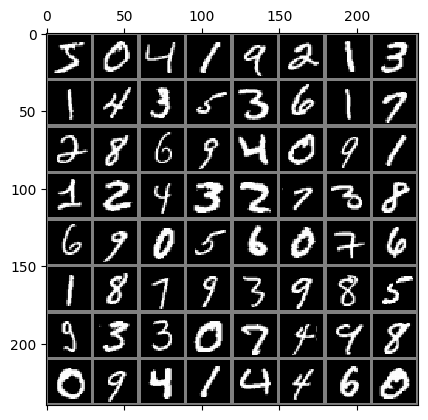

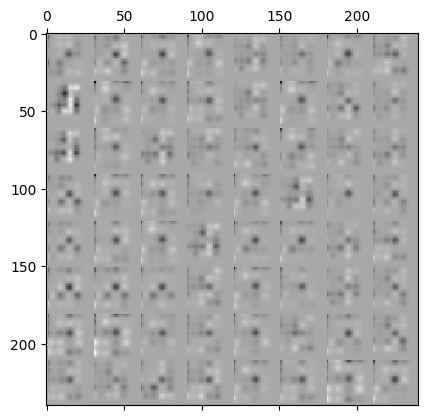

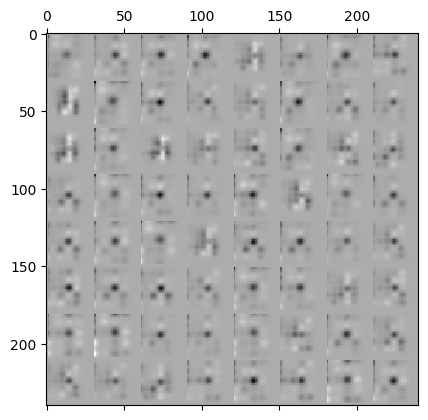

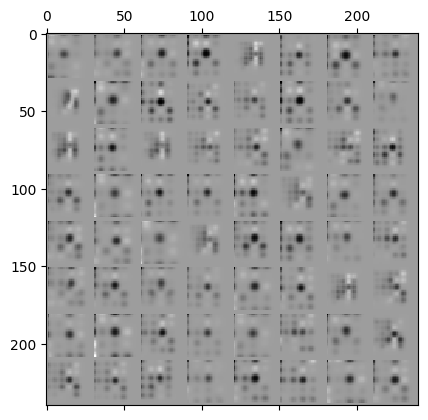

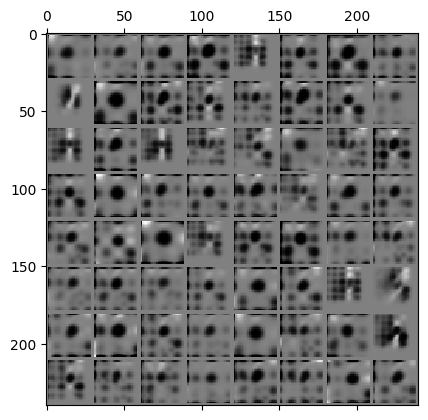

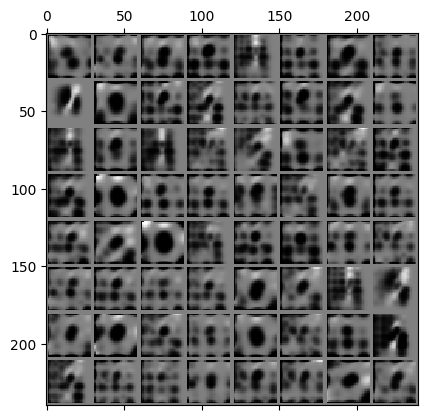

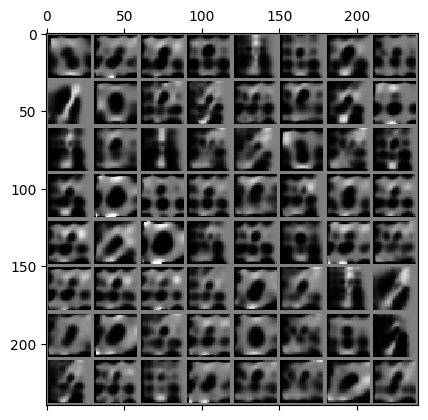

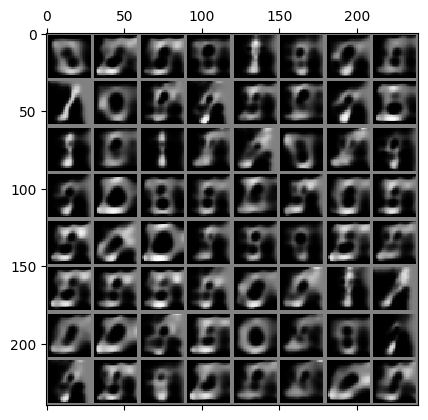

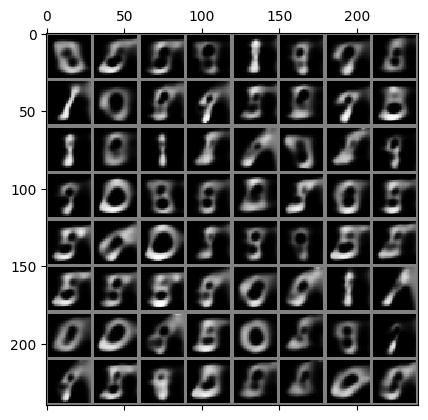

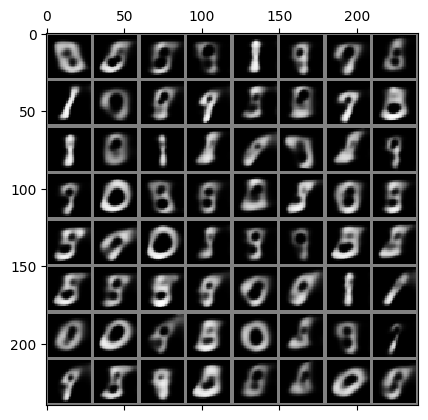

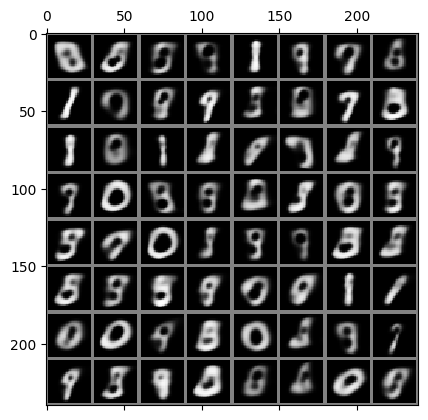

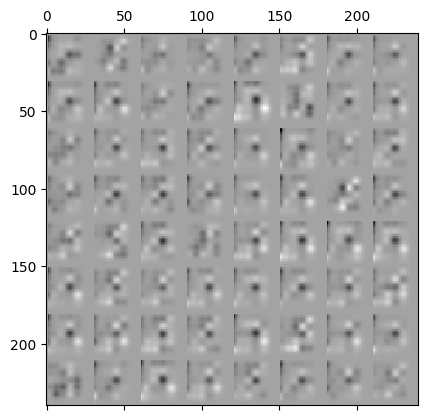

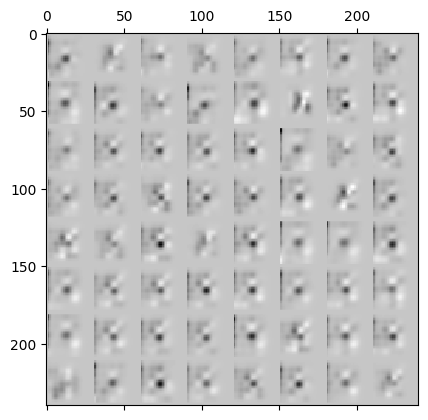

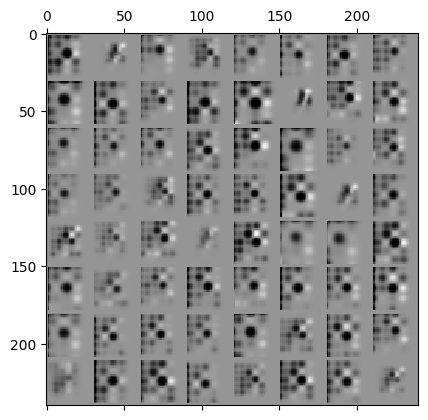

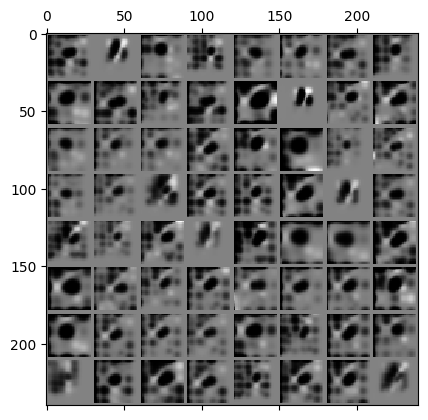

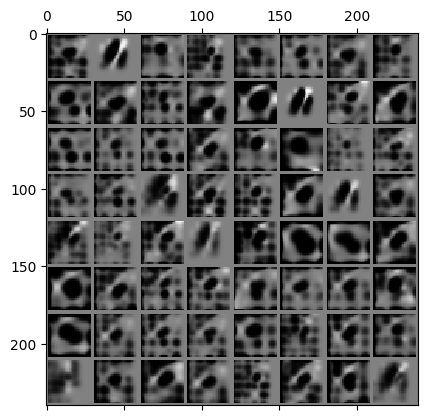

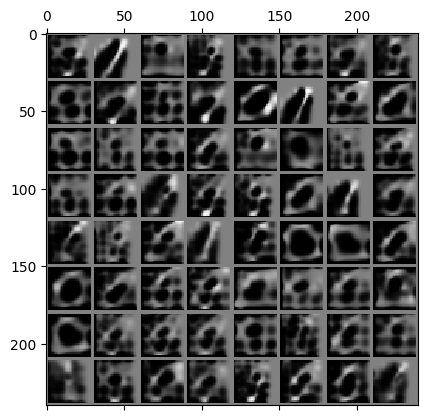

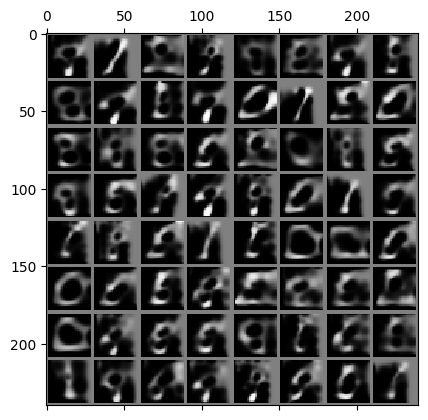

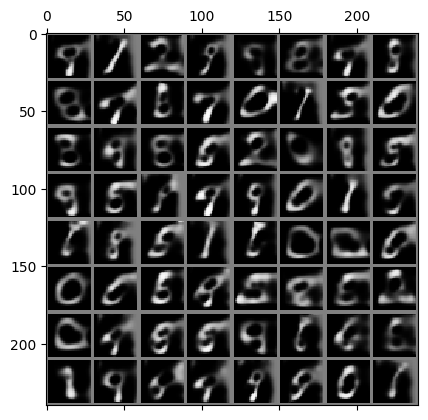

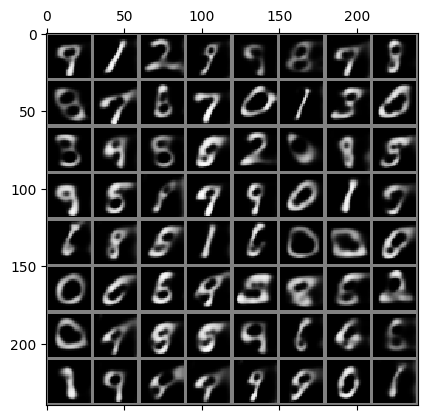

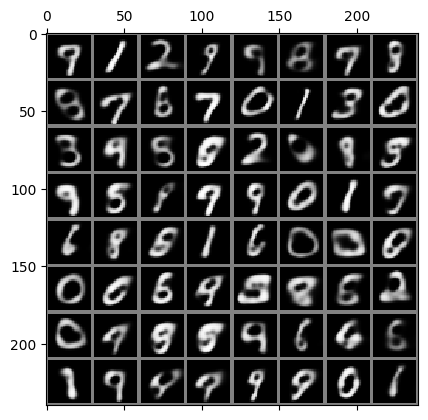

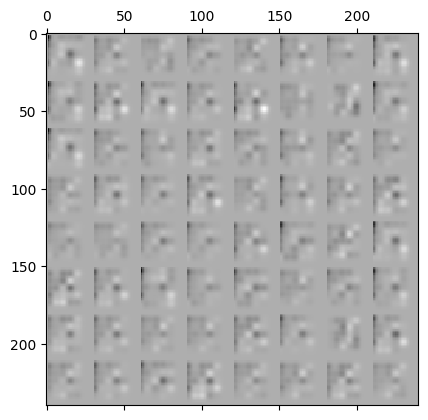

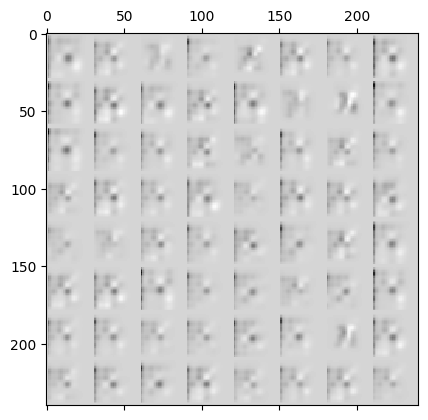

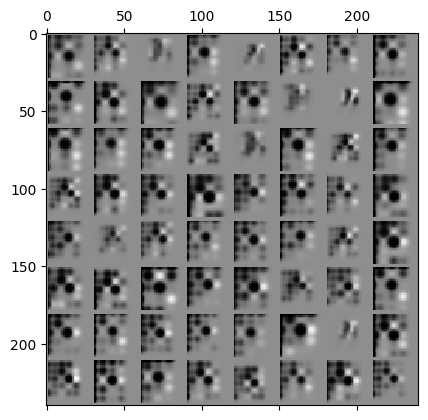

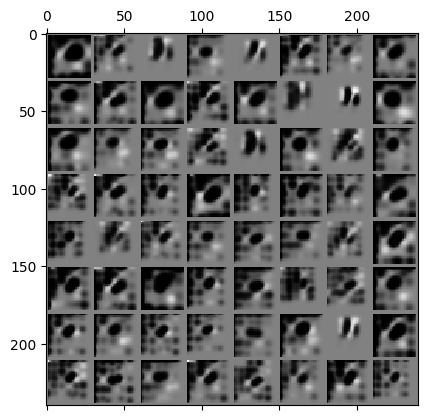

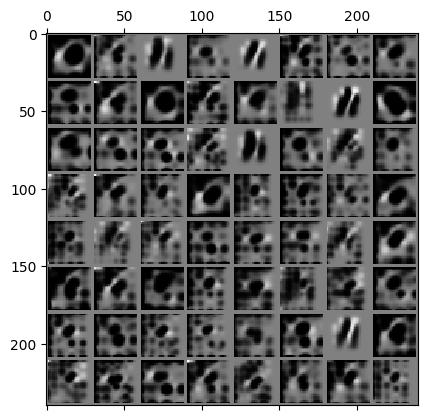

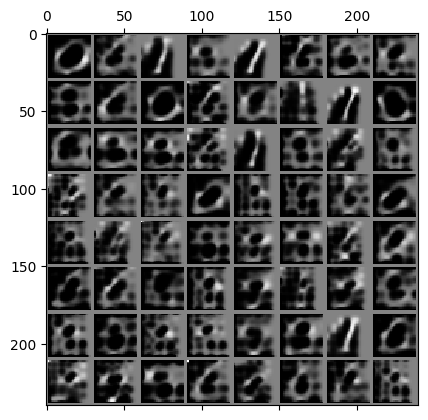

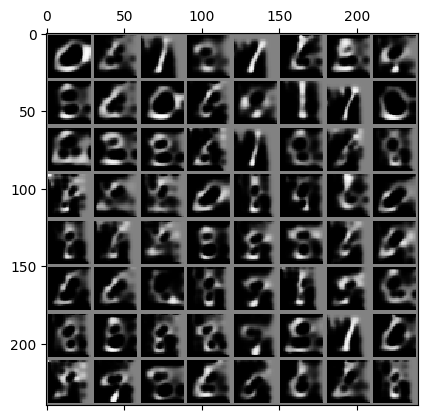

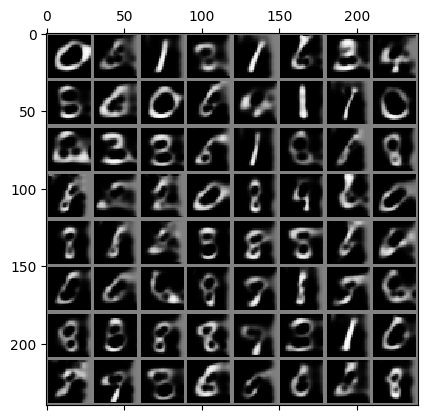

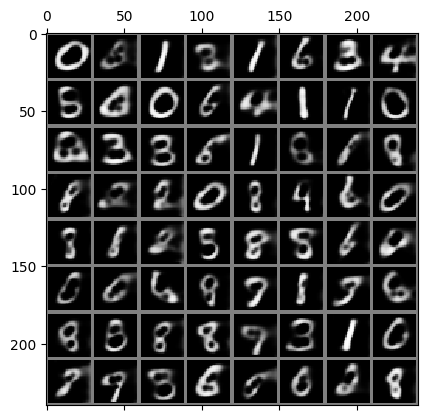

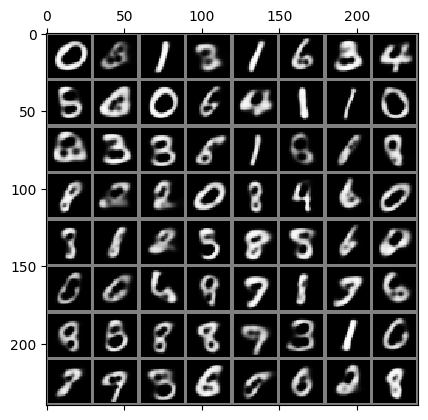

In [16]:
import time

train_hist = {}
train_hist['loss'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []

start_time = time.time()

save_example_image()

avg_loss = 0
count = 0

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    for i, (data, _) in enumerate(train_loader):
        if i == train_loader.dataset.__len__() // batch_size:
            break

        batch_size = data.size()[0]
        data = data.view(batch_size, -1)
        
        if USE_CUDA:
            data = data.cuda()
        
        optimizer.zero_grad()
            
        loss = model.loss(data)
        train_hist['loss'].append(loss.item())
        
        avg_loss += loss.cpu().data.numpy()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        count += 1
            
        train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
        
        if (i + 1) % 100 == 0:
            print('Epoch [%d/%d], Step[%d/%d], loss: %.4f'
                  %(epoch, num_epochs, (i + 1), train_loader.dataset.__len__() // batch_size, avg_loss / 100))

        if count % 100 == 0:
            if count % 3000 == 0:
                torch.save(model.state_dict(), model_dir + '/draw_%d.pkl'%(count))
                generate_image(model, count)
            avg_loss = 0
            
torch.save(model.state_dict(), model_dir + '/draw.pkl')

train_hist['total_time'].append(time.time() - start_time)
print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(train_hist['per_epoch_time']), num_epochs, train_hist['total_time'][0]))